<a href="https://colab.research.google.com/github/dlsyscourse/lecture4/blob/main/5_automatic_differentiation_implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lecture 5: Automatic Differentiation Framework Implementation

In this lecture, we will walk through the design elements of an automatic differentiation framework.

We won't implement the automatic differentiation(that is part of your homework), but we will walk through all the scaffolds that build up our overall framework.




## Prepare the codebase

To get started, we can clone the following repo from the github. 

In [5]:
# Code to set up the assignment
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/
!mkdir -p 10714f22
%cd /content/drive/MyDrive/10714f22
# NOTE: Run the following line
# - uncomment the following line if you run this section for the first time
# - comment and skip the following line when you run this section for a second time
#   so you will have a local copy of lecture4 under 10714f22/lecture4 that you can
#   continue to edit and play with
# !git clone https://github.com/dlsyscourse/lecture4 
!ln -s /content/drive/MyDrive/10714f22/lecture4 /content/needle

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive
/content/drive/MyDrive/10714f22
Cloning into 'lecture4'...
remote: Enumerating objects: 19, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 19 (delta 3), reused 15 (delta 3), pack-reused 0
Unpacking objects: 100% (19/19), done.


We can then run the following command to make the path to the package available in colab's environment as well as the PYTHONPATH.

In [2]:
%set_env PYTHONPATH /content/needle/python:/env/python
import sys
sys.path.append("/content/needle/python")

env: PYTHONPATH=/content/needle/python:/env/python


## Needle codebase walkthrough

Now click the files panel on the left side. You should be able to see the following files: 

- `needle/python/needle`
    - `__init__.py`
    - `auograd.py`
    - `ops.py`

Our framework is called needle. Needle stands for **ne**cessary **e**lements of **d**eep **le**arning.
You can also viewed it as a sewing needle that threads through clothes
to form (neural)net patterns, and the create traces for automatic differentiation.




### Tensor creation and manipulation




In [3]:
import needle as ndl

We can call perform array operations on needle Tensors. The following code creates a new Tensor y by adding a constant scalar to x.

In [4]:
x = ndl.Tensor([1, 2, 3], dtype="float32")

In [5]:
y = ndl.add_scalar(x, 1)

In [6]:
y

needle.Tensor([2. 3. 4.])

We provide common operator overloadingss so you can also directly write + and the call redirects to ndl.add_scalar.

In [7]:
y = x + 1

In [8]:
y

needle.Tensor([2. 3. 4.])

We can call `y.numpy()` to explicitly convert a needle Tensor to a numpy ndarray. Note for numpy backend, needle tensor is backed by an numpy.ndarray so there isn't much a difference here. However, we will implement other non-numpy backends that are backed by different kind of devices.

In [9]:
y.numpy()

array([2., 3., 4.], dtype=float32)

### Key Data Structures

Needle contains the following key data structures:

- Value: represent a value "node" in a computational graph
    - Tensor is a subclass of Value.
    - We might introduce other kinds of Value in the future (e.g. tuple of tensors)
- Op: represent the kind of computation we perform at each node.



## Computational Graph

When running array computations, needle not only executes the arithmetic operations, but also creates a computational graph along the way.

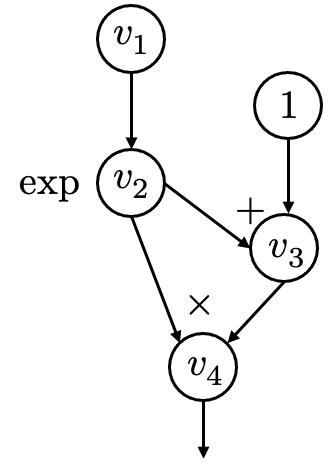

In [10]:
v1 = ndl.Tensor([0], dtype="float32")
v2 = ndl.exp(v1)
v3 = v2 + 1
v4 = v2 * v3

`v4.inputs` contains the input values to the operation


In [11]:
v4.inputs

(needle.Tensor([1.]), needle.Tensor([2.]))

We further confirm that `v4.inputs == [v2, v3]`

In [12]:
v4.inputs[0] is v2 and v4.inputs[1] is v3

True

Besides the inputs field. v4 also contains an `op` field that record the operaiton performed. In this case the operation is EWiseMulOp.

In [13]:
v4.op

v3 is an add scalar node that represents a constant scalar add to an input. 




In [14]:
v3.op

v3 only have one input(v2)


In [15]:
v3.inputs

(needle.Tensor([1.]),)

v3's op class also contains a field that stores the scalar constant

In [19]:
v3.op.__dict__

{'scalar': 1}

## Executing the Computation

Now let us take a deeper look at what happens when we run an array operation.
Specifically, what happens when we run `ndl.exp`

In [20]:
x1 = ndl.Tensor([3], dtype="float32")
x2 = ndl.Tensor([4], dtype="float32")
x3 = x1 * x2

In [21]:
x3

needle.Tensor([12.])

Open up the code browser, check the following functions along the calling path.
- `autograd.TensorOp.__call__` calls into
- `autograd.Tensor.make_from_op` calls into
- `autograd.Tensor.realize_cached_data` calls into
- `x3.op.compute`

A few key points to note here:
- `make_from_op` constructs the computational graph node. 
- The actual computation won't happen until `realize_cached_data` is called.


In [22]:
x3.op.compute.__code__

<code object compute at 0x7f450df121e0, file "/content/needle/python/needle/ops.py", line 42>

The following code above us to find the location of the compute implementation. 
- Here `array_api` simply points to numpy
- In the later lectures, we will replace `array_api` with our own implementation of NDArray.


Each of the Value node stores a `cached_data` field that corresponds to the computed data. Because we are using numpy as our array api, the cached_data is a numpy.ndarray.

In [23]:
type(x3.cached_data)

numpy.ndarray

In [24]:
x3.cached_data

array([12.], dtype=float32)

### Lazy Evaluation

We also support a lazy evaluation mode. In this case, we do not compute cached_data right away. But cached_data will be computed once we need the actual result (when we call x3.data, x3.numpy() or othercases).


In [25]:
ndl.autograd.LAZY_MODE = True
x1 = ndl.Tensor([3], dtype="float32")
x2 = ndl.Tensor([4], dtype="float32")
x3 = x1 * x2

We can see that x3's cached_data field is not yet readily available. But as soon as we call x3.numpy(), a call to `x3.realize_cached_data()` will get triggered to compute the actual value.

In [26]:
x3.cached_data is None

True

In [27]:
x3.numpy()

array([12.], dtype=float32)

In [28]:
x.cached_data

array([1., 2., 3.], dtype=float32)

By default we use eager evaluation mode that always directly realizes the computation, but lazy evaluation can also be helpful for some advanced optimizations later.

## Reverse mode AD

Now we are ready to talk about reverse mode AD. As a recap from last lecture, we will need to traverse the computational graph in reverse topological order, and construct the new adjoint nodes(Tensors).

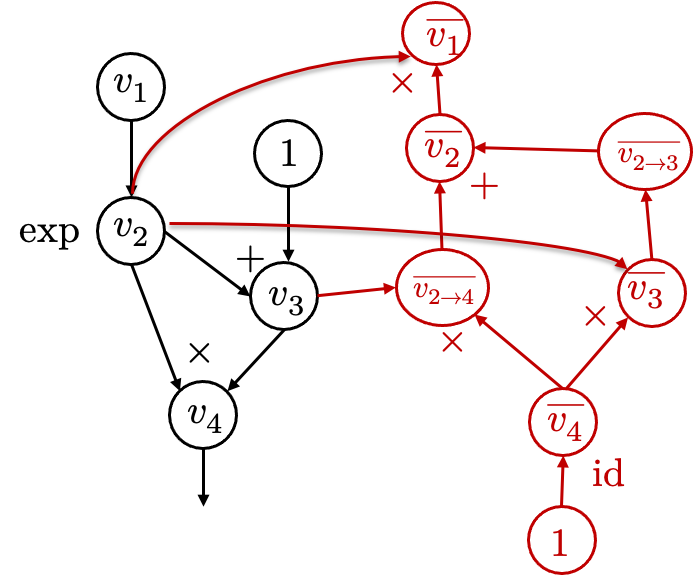

You will need to complete the implementations in autograd.py to enable the backward function. That computes the gradient and store them in the grad field of each input Tensor.

In [29]:
v1 = ndl.Tensor([0], dtype="float32")
v2 = ndl.exp(v1)
v3 = v2 + 1
v4 = v2 * v3

Each op have a gradient function, that defines how to propagate adjoint back into its inputs(as partial adjoints). We can look up the gradient implementation of v4.op as follows(impl of gradient for multiplication)


In [30]:
v4.op.gradient.__code__

<code object gradient at 0x7f450df12270, file "/content/needle/python/needle/ops.py", line 45>

In [31]:
v4.op

The gradient function defines a single step to propagate the output adjoint to partial adjoints of its inputs.

In [32]:
in_grads = v4.op.gradient(ndl.Tensor([1], dtype="float32"), v4)
in_grads[0].inputs

(needle.Tensor([1.]), needle.Tensor([2.]))

## Additional Remarks

While needle is designed as a minimalist framework, it contains a comprehensive the bells and whistles of standard deep learning frameworks.

- Read and think about the relation between Tensor, array_api and underlying NDArray.
- Think about how gradient are implemented.